# Proyek Klasifikasi Gambar: Rumah Adat Indonesia
Datasets from : https://www.kaggle.com/datasets/rariffirmansah/rumah-adat/data

- **Nama:** Fiyanda Ma'muri
- **Email:** fiyandamamuri@gmail.com
- **ID Dicoding:** fiyandamamuri

## Import Semua Packages/Library yang Digunakan

In [23]:
import os
import pandas as pd
import shutil
import random
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


## Data Preparation

### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Menentukan path file zip dan tujuan ekstraksi
zip_path = '/content/drive/MyDrive/datasets/rumah_adat.zip'
extract_path = '/content/datasets'

# Mengekstrak isi file zip
with zipfile.ZipFile(zip_path) as zip_ref:
    zip_ref.extractall(extract_path)

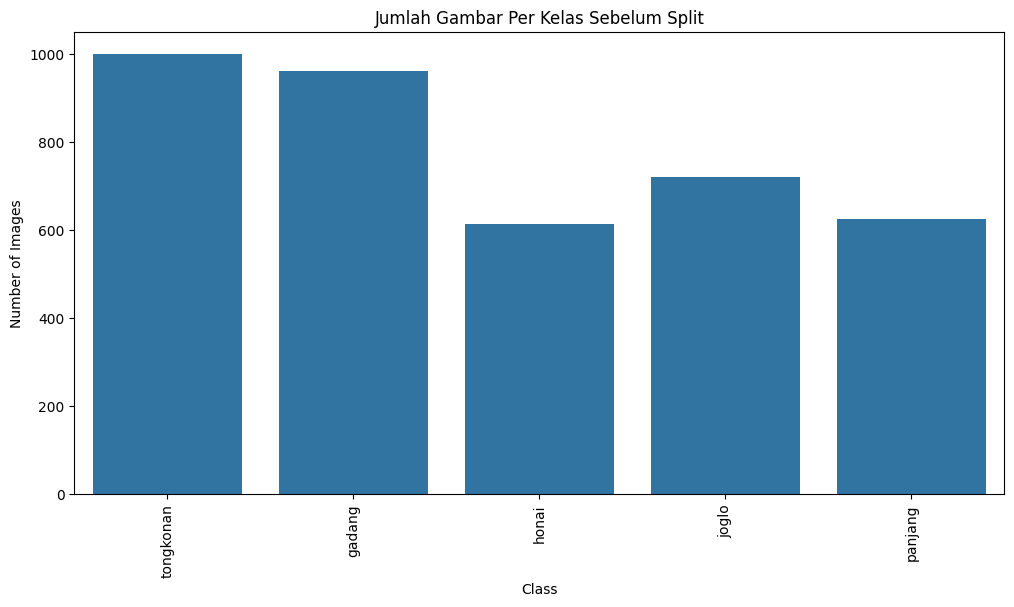

In [5]:
# Path dataset sebelum split
image_data = '/content/datasets/rumah_adat'

# Menghitung jumlah gambar di setiap kelas (folder)
class_counts = []
class_names = []

for class_name in os.listdir(image_data):
    class_path = os.path.join(image_data, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya membaca folder
        num_images = len(os.listdir(class_path))
        class_counts.append(num_images)
        class_names.append(class_name)

# Membuat DataFrame
df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Visualisasi dengan seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Count", data=df)
plt.xticks(rotation=90)  # Rotasi label agar tidak tumpang tindih
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Jumlah Gambar Per Kelas Sebelum Split")
plt.show()

In [6]:
df

,Class,Count
0,tongkonan,1000
1,gadang,962
2,honai,613
3,joglo,720
4,panjang,624


### Data Preprocessing

#### Split Dataset

In [7]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.8, val_ratio=0.16):
    """
    Membagi dataset ke dalam folder Train, Validation, dan Test.

    Parameters:
    source_dir (str): Path dataset asli.
    train_dir (str): Path untuk dataset training.
    val_dir (str): Path untuk dataset validation.
    test_dir (str): Path untuk dataset testing.
    train_ratio (float): Proporsi data untuk training (default: 80%).
    val_ratio (float): Proporsi data untuk validation (default: 16%).
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        train_split = int(train_ratio * len(images))
        val_split = int(val_ratio * len(images))

        train_images = images[:train_split]
        val_images = images[train_split:train_split + val_split]
        test_images = images[train_split + val_split:]

        # Buat folder untuk setiap kelas
        for dataset_dir, dataset_images in zip([train_dir, val_dir, test_dir],
                                               [train_images, val_images, test_images]):
            class_dest = os.path.join(dataset_dir, class_name)
            if not os.path.exists(class_dest):
                os.makedirs(class_dest)

            for img in dataset_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(class_dest, img))

# Path dataset asli dan tujuan
source_dataset = "/content/datasets/rumah_adat"
train_dataset = "/content/datasets/Train"
val_dataset = "/content/datasets/Validation"
test_dataset = "/content/datasets/Test"

# Jalankan fungsi split
split_dataset(source_dataset, train_dataset, val_dataset, test_dataset)

print("Dataset berhasil dibagi menjadi Train, Validation, dan Test!")


Dataset berhasil dibagi menjadi Train, Validation, dan Test!


#### Augmentasi Data

In [8]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder yang telah dibagi
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 3134 images belonging to 5 classes.
Found 625 images belonging to 5 classes.
Found 160 images belonging to 5 classes.


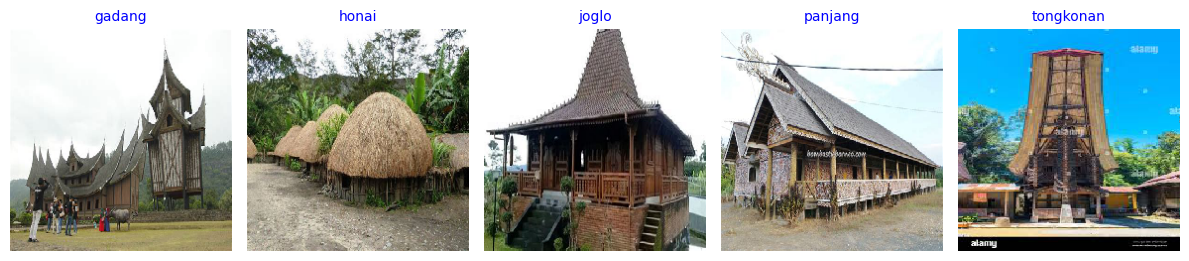

In [9]:
# Mendapatkan informasi kelas dari generator
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Dictionary untuk menyimpan satu contoh gambar per kelas
selected_images = {}
selected_labels = {}

# Looping batch sampai semua kelas terwakili
for _ in range(len(test_generator)):  # Loop hingga semua batch diproses
    images, labels = next(test_generator)

    for i in range(len(images)):
        index = np.argmax(labels[i])  # Mendapatkan indeks kelas
        class_name = classes[index]   # Mendapatkan nama kelas

        # Jika kelas ini belum tersimpan, tambahkan ke dictionary
        if class_name not in selected_images:
            selected_images[class_name] = images[i]
            selected_labels[class_name] = class_name

        # Jika sudah cukup (semua kelas ada), hentikan pencarian
        if len(selected_images) == len(classes):
            break
    if len(selected_images) == len(classes):
        break

# Menampilkan hasil visualisasi
plt.figure(figsize=(12, 8))

for idx, (class_name, image) in enumerate(selected_images.items()):
    plt.subplot(1, 5, idx + 1)  # Sesuaikan grid dengan jumlah kelas
    image = image.squeeze() if image.shape[-1] == 1 else image  # Handle grayscale
    plt.imshow(image)
    plt.title(class_name, color='blue', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Modelling

In [10]:
# Ukuran input gambar
input_shape = (224, 224, 3)

# Load base MobileNetV2 (tanpa top) - pretrained ImageNet
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Bekukan bobot pretrained

# model Sequential
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # 5 kelas rumah adat
])

# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Ringkasan model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,086,341 (11.77 MB)

 Trainable params: 828,357 (3.16 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Custom Callback
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.98):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:
            print(f"\nTraining dihentikan karena akurasi telah mencapai {logs.get('accuracy'):.2f}")
            self.model.stop_training = True

# Callbacks untuk optimasi training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.98)

In [12]:
# Melakukan training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), StopAtAccuracy()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.6332 - loss: 1.0734 - precision: 0.7198 - recall: 0.5441 - val_accuracy: 0.9760 - val_loss: 0.0820 - val_precision: 0.9838 - val_recall: 0.9712
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 294ms/step - accuracy: 0.9391 - loss: 0.1875 - precision: 0.9528 - recall: 0.9247 - val_accuracy: 0.9840 - val_loss: 0.0653 - val_precision: 0.9871 - val_recall: 0.9808
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 295ms/step - accuracy: 0.9575 - loss: 0.1377 - precision: 0.9662 - recall: 0.9498 - val_accuracy: 0.9824 - val_loss: 0.0642 - val_precision: 0.9887 - val_recall: 0.9808
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - accuracy: 0.9612 - loss: 0.1175 - precision: 0.9707 - recall: 0.9569 - val_accuracy: 0.9808 - val_loss: 0.0727 - val_precision: 0.9823 - val_recall: 0.9792
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 57s 290ms/step - accuracy: 0.9674 - loss: 0.0920 - precision: 0.9715 - recall: 0.9634 - val_accuracy: 0.9808

## Evaluasi dan Visualisasi

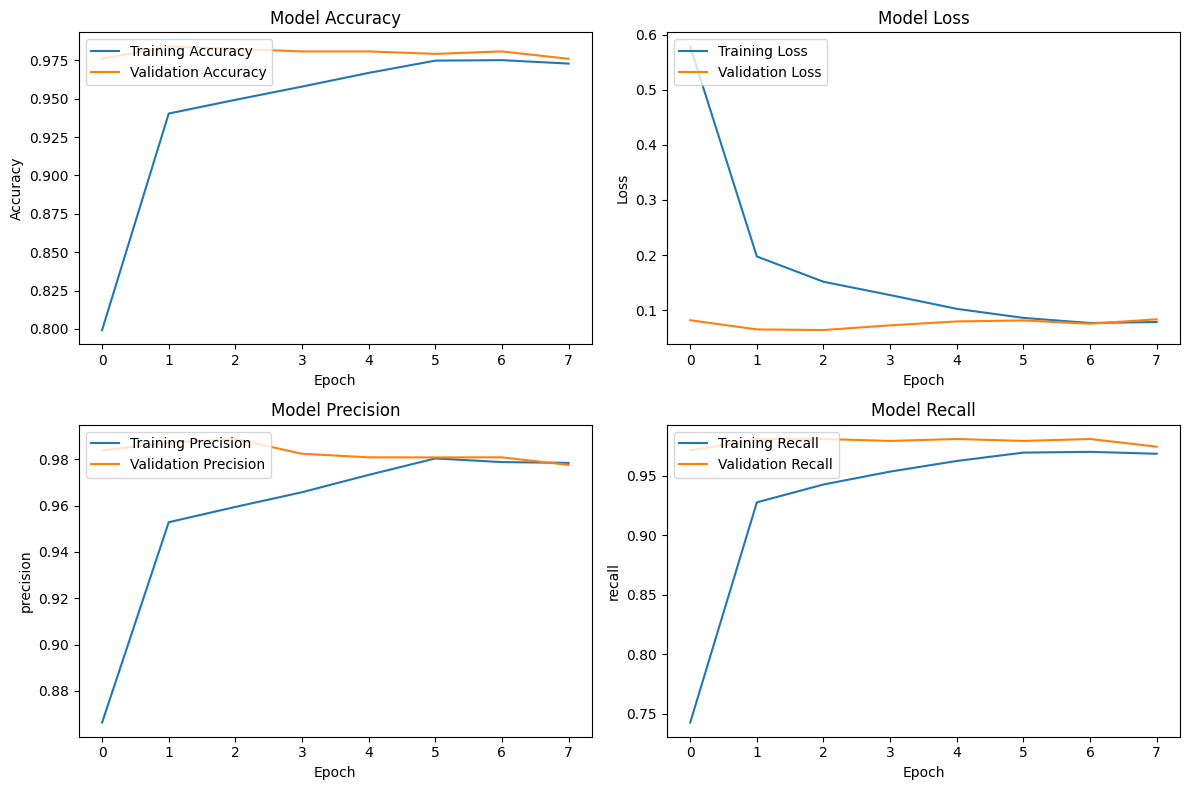

In [13]:
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


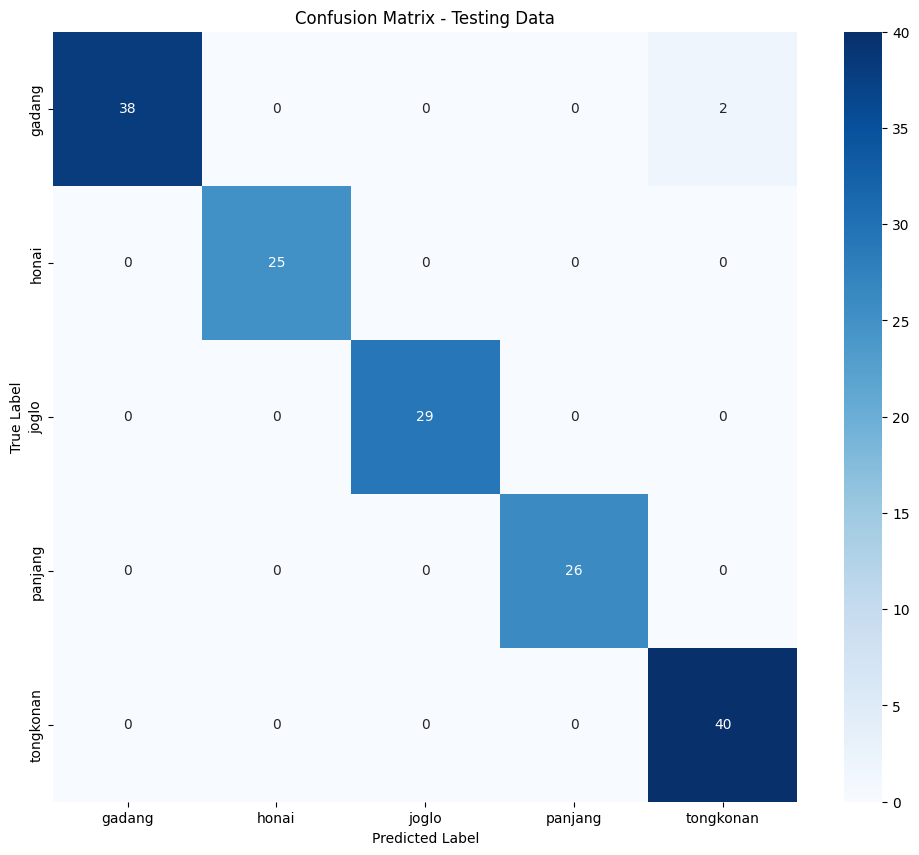


Classification Report (Data Testing):
              precision    recall  f1-score   support

      gadang       1.00      0.95      0.97        40
       honai       1.00      1.00      1.00        25
       joglo       1.00      1.00      1.00        29
     panjang       1.00      1.00      1.00        26
   tongkonan       0.95      1.00      0.98        40

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [14]:
# evaluasi data testing
# Mendapatkan label kelas dari generator
class_labels = list(train_generator.class_indices.keys())

# Mengambil semua gambar dari test set
y_true = []
y_pred = []

# Looping melalui seluruh test dataset
for images, labels in test_generator:
    predictions = model.predict(images)  # Prediksi model
    y_true.extend(np.argmax(labels, axis=1))  # Label sebenarnya
    y_pred.extend(np.argmax(predictions, axis=1))  # Label prediksi

    if len(y_true) >= test_generator.samples:
        break  # Hentikan setelah seluruh dataset diuji

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Testing Data')
plt.show()

# Menampilkan Classification Report
print("\nClassification Report (Data Testing):")
print(classification_report(y_true, y_pred, target_names=class_labels))


## Konversi Model

In [15]:
# format .h5
model.save("model.h5")

In [17]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [18]:
# format tfjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-22 13:27:22.123827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745328442.177235   17394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745328442.196015   17394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [19]:
# format saved_model
tf.saved_model.save(model, "saved_model")

In [20]:
# format tf-lite

# Load model dari folder saved_model
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")

# (Opsional) optimasi agar ukuran file lebih kecil
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert ke TFLite
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil disimpan dalam format TFLite ✅")

Model berhasil disimpan dalam format TFLite ✅


## Inference (Optional)

In [24]:
def predict_uploaded_image(model, class_labels, img_size=(224, 224)):

    # Upload gambar
    uploaded = files.upload()  # Ini hanya bekerja di Google Colab

    for filename in uploaded.keys():
        try:
            # Load gambar dan ubah ukurannya
            img = Image.open(filename).convert('RGB')  # Pastikan dalam format RGB
            img = img.resize(img_size)

            # Konversi ke array dan normalisasi
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Prediksi menggunakan model
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction)
            predicted_label = class_labels[predicted_class]

            # Tampilkan gambar dan hasil prediksi
            plt.imshow(img)
            plt.title(f'Predicted Class: {predicted_label}', fontsize=14, color='blue')
            plt.axis('off')
            plt.show()

            print(f"Predicted Class: {predicted_label}")

        except Exception as e:
            print(f"[ERROR] Gagal memproses gambar {filename}: {e}")

Saving image.jpg to image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


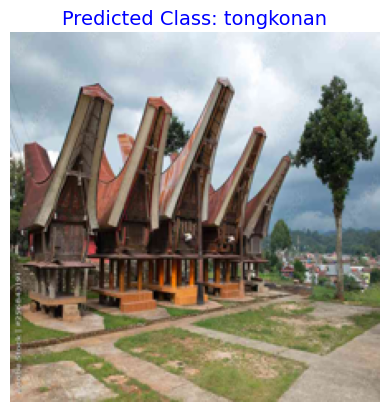

Predicted Class: tongkonan


In [25]:
# Pastikan model sudah dilatih dan class_labels diambil dari generator
class_labels = list(train_generator.class_indices.keys())

# Panggil fungsi prediksi
predict_uploaded_image(model, class_labels)

In [26]:
!pip freeze > requirements.txt

In [27]:
# Zip folder saved_model
!zip -r saved_model.zip saved_model/

# Zip folder tfjs_model
!zip -r tfjs_model.zip tfjs_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/assets/ (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 97%)


In [28]:
# Unduh file ZIP
files.download('saved_model.zip')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>